In [1]:
import xarray as xr
import os
import numpy as np

# =====================================================
# PATHS
# =====================================================
# Update this to your NEW sequences folder
SEASONAL_DIR = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/seasonal_sequences"
YIELD_DIR    = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/rounded_farm"
OUTPUT_DIR   = "/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield"

os.makedirs(OUTPUT_DIR, exist_ok=True)

YEARS = range(1991, 2024)

for year in YEARS:
    print(f"🔄 Merging yield for {year}...")

    # 1. Load Data
    seasonal_ds = xr.open_dataset(os.path.join(SEASONAL_DIR, f"seasonal_features_{year}.nc"))
    yield_ds = xr.open_dataset(os.path.join(YIELD_DIR, f"wheat_farm_{year}.nc"))

    # 2. Identify Yield Variable
    if "H_wheat_dot_hat" in yield_ds.data_vars:
        yvar = "H_wheat_dot_hat"
    elif "wheat_yield" in yield_ds.data_vars:
        yvar = "wheat_yield"
    else:
        raise ValueError(f"No yield variable found in {year}")

    yield_da = yield_ds[yvar]

    # Drop time dim from yield if it exists (it should be static spatial map)
    if "time" in yield_da.dims:
        yield_da = yield_da.squeeze("time", drop=True)

    # =====================================================
    # 🛠️ THE FIX: COORDINATE ALIGNMENT
    # =====================================================
    print(f"   ...Aligning coordinates for {year}")

    # We force the Seasonal Data (Climate) to snap to the Yield Data's grid.
    # method='nearest' ensures we don't interpolate values, just pick the closest grid cell.
    # tolerance=0.01 protects us from matching far-away pixels if the grids are totally different.

    seasonal_aligned = seasonal_ds.interp(
        lat=yield_da.lat,
        lon=yield_da.lon,
        method="nearest"
    )

    # =====================================================
    # 3. Merge
    # =====================================================
    final_ds = xr.merge(
        [seasonal_aligned, yield_da.rename("yield")],
        compat="override" # Force merge since coords are now identical
    )

    # 4. Metadata & Save
    final_ds.attrs.update({
        "title": "Seasonal Climate Sequences & Yield (Aligned)",
        "year": year,
        "season": "May–October",
        "yield_type": "Annual wheat yield",
        "alignment_fix": "interp_nearest to yield grid"
    })

    out_file = os.path.join(OUTPUT_DIR, f"final_dataset_{year}.nc")
    final_ds.to_netcdf(out_file)

    print(f"✅ Saved {out_file}")

print("🎉 Stripes removed & Merged successfully!")

🔄 Merging yield for 1991...
   ...Aligning coordinates for 1991
✅ Saved /content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield/final_dataset_1991.nc
🔄 Merging yield for 1992...
   ...Aligning coordinates for 1992
✅ Saved /content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield/final_dataset_1992.nc
🔄 Merging yield for 1993...
   ...Aligning coordinates for 1993
✅ Saved /content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield/final_dataset_1993.nc
🔄 Merging yield for 1994...
   ...Aligning coordinates for 1994
✅ Saved /content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield/final_dataset_1994.nc
🔄 Merging yield for 1995...
   ...Aligning coordinates for 1995
✅ Saved /content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPE

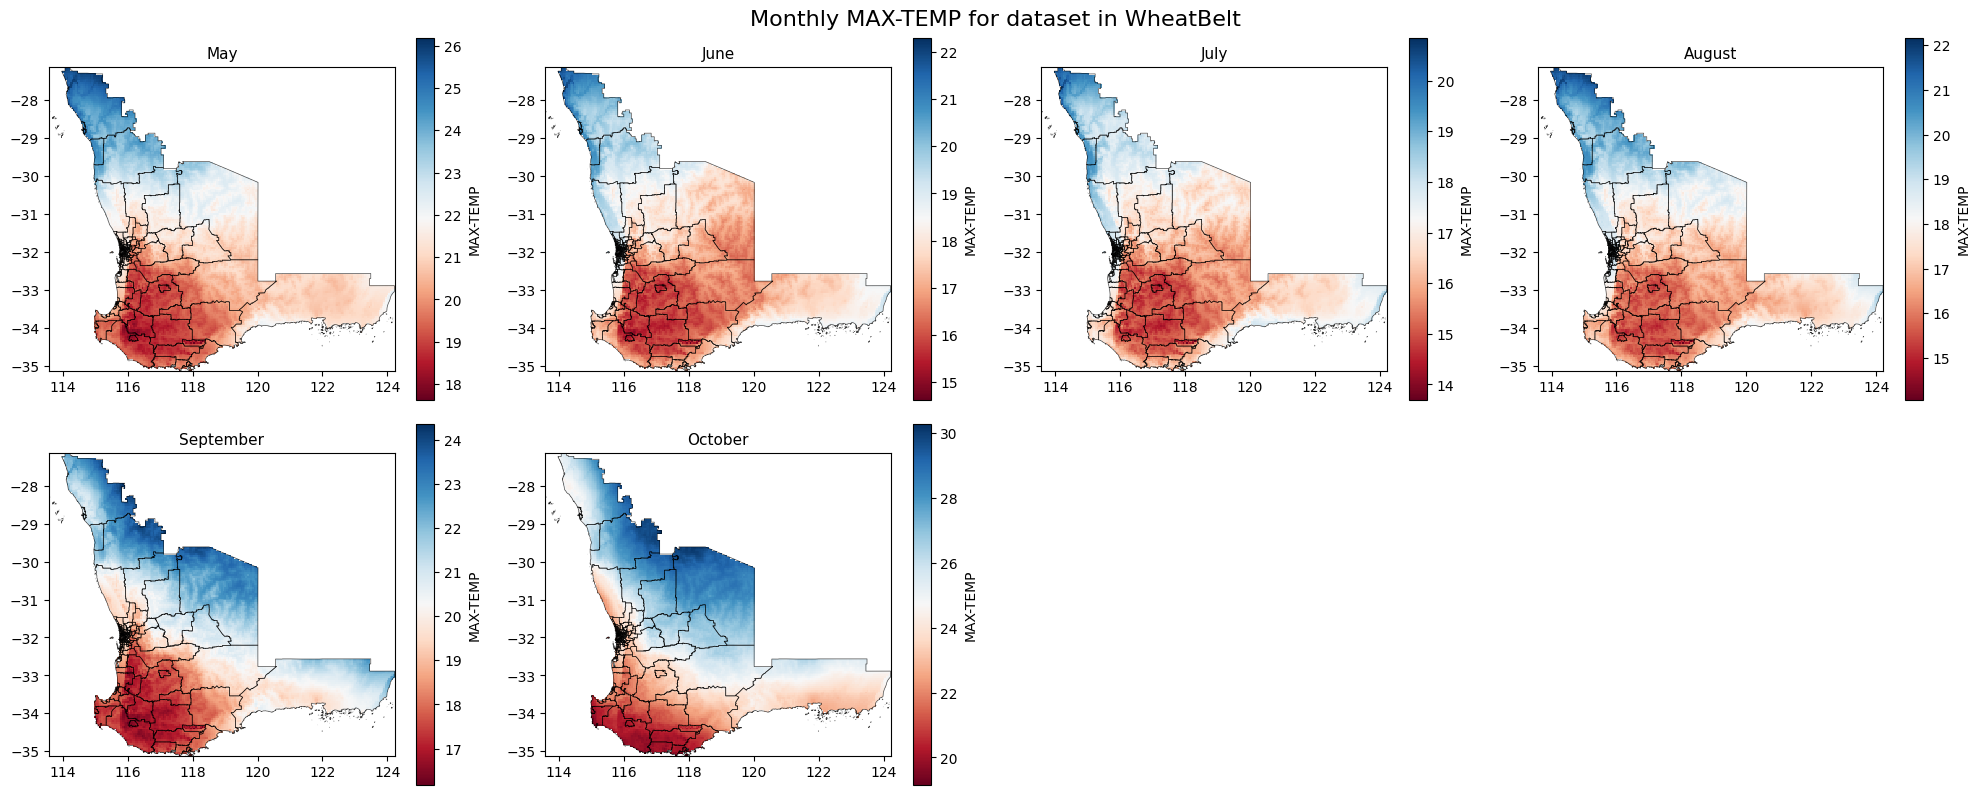

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

# === Load the shapefile ===
shapefile_path = r'/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Eastern_Aus_Bunbury/Eastern_Aus_Bunbury.shp'
qld_shape = gpd.read_file(shapefile_path).to_crs("EPSG:4326")

# === Open the SPI dataset ===
nc_path = Path(r'/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_sequence_with_yield/final_dataset_1991.nc')
year = nc_path.stem.split('_')[1]

ds = xr.open_dataset(nc_path)

# === Select SPI variable ONCE ===
var_name = 'max_temp'          # change here: spi_3, spi_6, etc.
monthly_rain = ds[var_name]

# === Convert variable name to display label ===
spi_label = var_name.replace('_', '-').upper()   # spi_1 → SPI-1

# === Fix metadata so colorbar label is correct ===
monthly_rain.attrs.pop('units', None)
monthly_rain.attrs['long_name'] = spi_label

# === Create figure and axes ===
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))
axes = axes.flatten()

# === Plot each month ===
for i, month in enumerate(monthly_rain.time):
    ax = axes[i]
    data = monthly_rain.sel(time=month)

    data.plot(
        ax=ax,
        cmap='RdBu',
        add_colorbar=True
    )

    # Overlay region boundaries
    qld_shape.boundary.plot(
        ax=ax,
        color='black',
        linewidth=0.5,
        alpha=0.7
    )

    # Titles and formatting
    ax.set_title(month.dt.strftime('%B').item(), fontsize=11)
    ax.set_xlabel('')
    ax.set_ylabel('')

# === Remove unused subplots ===
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# === Figure title (automatic) ===
plt.suptitle(
    f'Monthly {spi_label} for {year} in WheatBelt',
    fontsize=16,
    y=0.98
)

plt.tight_layout()
plt.show()


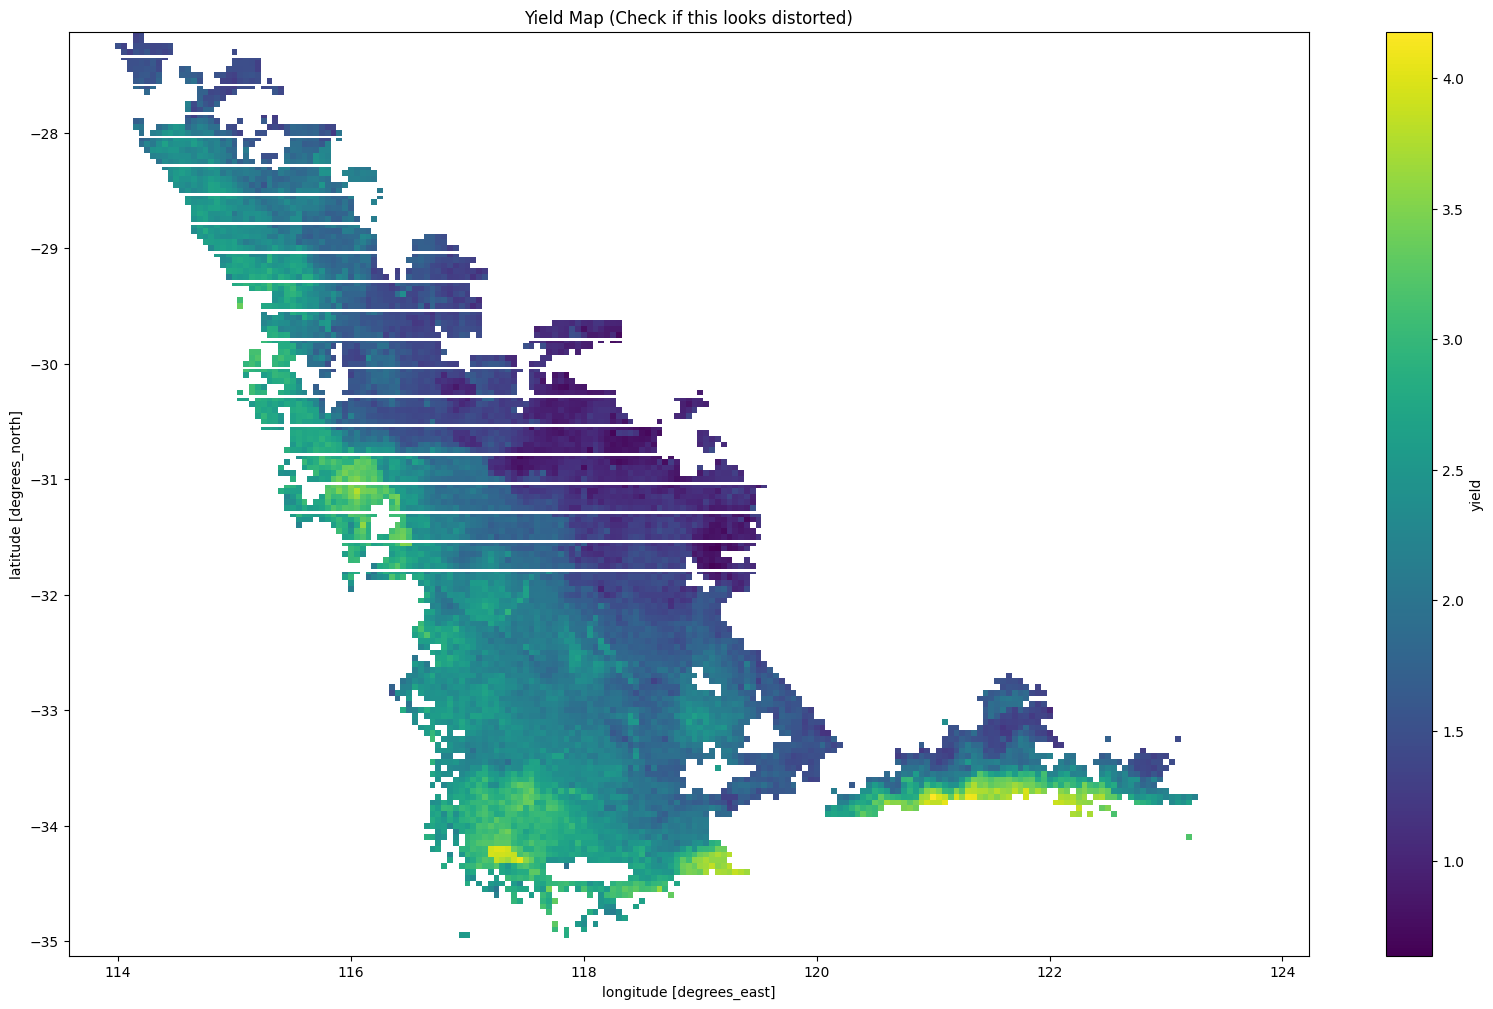

In [4]:
import matplotlib.pyplot as plt
import xarray as xr

# Load one merged file
ds = xr.open_dataset("/content/drive/MyDrive/Research Works - Development/Work 2 - SPI SPEI/Data/raster/Data for Dev/final_with_yield/final_dataset_1995.nc")

# Plot Yield
plt.figure(figsize=(20, 12))
ds['yield'].plot(cmap='viridis')
plt.title("Yield Map (Check if this looks distorted)")
plt.show()